In [69]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch

In [70]:
#here set up the path of your file, a priori it should be on same directory
data = pd.read_csv("ibtracs.last3years.list.v04r00.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 06:00:00,NR,2.00000,-173.500,...,,,,,,,,,3,73
2,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 09:00:00,NR,2.04500,-173.353,...,,,,,,,,,3,71
3,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 12:00:00,NR,2.10000,-173.200,...,,,,,,,,,3,67
4,2016005N02187,2016,1,EP,CP,PALI,2016-01-05 15:00:00,NR,2.17750,-173.042,...,,,,,,,,,4,56


In [71]:
#allows to keep only specific columns
def select_data(data):
    return data[['SID', 'NUMBER', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR']]#, 'BASIN', 'NATURE']]

#convert columns to numeric values
#and interpolate missing values
def numeric_data(data):
    for i in ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR']:
        data[i]=pd.to_numeric(data[i],errors='coerce').astype('float64')
        data[i]=data[i].interpolate(method='linear')
    return data

# df0 is  cleaned data 
df0 = select_data(data)
df0 = numeric_data(df0)

/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [72]:
df0.head()

,SID,NUMBER,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES,DIST2LAND,STORM_SPEED,STORM_DIR
0,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016005N02187,1,2016-01-05 06:00:00,2.0000,-173.500,25.0,1006.0,1738.0,3.0,73.0
2,2016005N02187,1,2016-01-05 09:00:00,2.0450,-173.353,25.0,1006.0,1737.0,3.0,71.0
3,2016005N02187,1,2016-01-05 12:00:00,2.1000,-173.200,25.0,1006.0,1748.0,3.0,67.0
4,2016005N02187,1,2016-01-05 15:00:00,2.1775,-173.042,25.0,1005.5,1759.0,4.0,56.0


In [73]:
def sort_storm(data, min_wind, min_steps = 5, max_steps = 120):
    '''function to create dictionary of storm matrices
    arguments: 
    data we want to cut
    min_wind: the minimum wind speed to store data 
    '''
    #get unique storm_id:
    SID=pd.unique(data['SID']).tolist()
    #remove empty SID
    SID.remove(' ') 
    #create empty dictionary
    dict0={}
    ind = 0
    for i in range(len(SID)):
        #get data of a particular SID
        M = data.loc[data['SID'] == SID[i]]
        #cut off using min wind speed
        #TODO : cut everything before, ie look for the right date
        try:
            t = M.index[M['WMO_WIND']>= min_wind][0]
            t0 = M.index[0]
        except:
            t = 0
        N = M.loc[M['WMO_WIND'] >= min_wind]
        #save matrix in dict0
        if N.shape[0] > min_steps:
            ind+=1
            dict0.update({ind:M.iloc[t-t0:max_steps+t-t0]})
    return dict0

#storms is the dictionary all storm matrices
storms = sort_storm(df0, min_wind=45, min_steps=15)

In [74]:
def pad_traj(dict0, max_steps, nan = False):
    dict1={}
    for t in dict0:
        num_steps = dict0[t].shape[0]
        steps2add = max_steps - num_steps
        if steps2add > 0:
            if nan:
                dict1[t] = pd.concat([dict0[t], pd.DataFrame([[np.nan] * dict0[t].shape[1]]*steps2add, columns=dict0[t].columns)], ignore_index=True)
            else:
                dict1[t] = pd.concat([dict0[t], pd.DataFrame([[0] * dict0[t].shape[1]]*steps2add, columns=dict0[t].columns)], ignore_index=True)                
        else:
            dict1[t] = dict0[t][:max_steps]
    return dict1

In [75]:
d = pad_traj(storms, 120)

In [76]:
#function to calculate tensor shape
    #input: dictionary of storm data
def tensor_shape(dict0):
    #number of storms
    num_storms=len(dict0) - 1
    #number of features
    num_features=dict0[next(iter(dict0))].shape[1]  
    
    #to compute min and max number of steps
    t_max = 0 #initialise 
    t_min = 1000
    t_hist = []
    for i in dict0:
        t0 = dict0[i].shape[0]
        t_hist.append(t0)
        if  t0 > t_max:
            t_max = t0
        if t0 < t_min:
            t_min = t0
    print("There are %s storms with %s features, and maximum number of steps is %s and minimum is %s." %(num_storms,num_features,t_max, t_min))
    return num_storms, num_features, t_max, t_min, t_hist     
    
#call tensor_shape 
m, n, t_max, t_min, t_hist = tensor_shape(d)

There are 111 storms with 10 features, and maximum number of steps is 120 and minimum is 120.


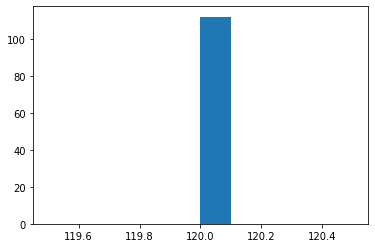

In [77]:
plt.hist(t_hist)
plt.show()

In [78]:
#create a tensor
def create_tensor(data):
    tensor = data[1]
    for i in range(2,m,1):
        tensor=np.dstack((tensor, data[i]))
    return tensor   

t = create_tensor(d)

In [79]:
t2=torch.Tensor(t[:,3:,:].astype('float64'))
t3=torch.transpose(t2,0,2)

In [86]:
t3.shape

torch.Size([110, 7, 120])

In [82]:
from __future__ import print_function
import torch
import numpy as np

dtype = torch.float
device = torch.device("cpu")

In [93]:
r=5
m,n,t=t3.shape


#SVD 
def mat_svd(X,r):
    #Mode-1 folding
    X1= X.reshape(m,n*t)
    U,S,V= torch.svd(X1,some=True, compute_uv=True) 
    U1=U[:,:r]
    #Mode-2 folding
    X2= X.reshape(m*t,n) 
    U,S,V= torch.svd(X2,some=True, compute_uv=True)
    V1=V[:,:r]
    print (U1.shape, V1.shape)
    return U1,V1

#Update S based on U1, V1
def update_s(U, X, V, r ):
    new_s = torch.empty((r,r,t))
    for i in range(t): 
        m1 = torch.mm(torch.t(U),X[:,:,i]) #torch.t = transpose
        m2 = torch.mm(m1,V)
        new_s[:,:,i]=m2
    return new_s

#Compute Z:
def update_z(U,V,S):
    new_z = torch.empty((m,n,t))
    for i in range(t): 
        S_t=S[:,:,i]
        m1 = torch.mm(U,S_t)
        m2 = torch.mm(m1,torch.t(V))
        new_z[:,:,i]=m2
    return new_z

#wrap up everything 
def tensor_svd1(Z0,r,T=50):
    #initialise Z
    Z1=Z0
    error=100
    for t in range(T):
        if error > 1: 
            print(t,error)
            R=Z1
            U1,V1= mat_svd(R,r)
            S=update_s(U1,R,V1,r)
            Z1=update_z(U1,V1,S)
            error=(Z1-Z0).pow(2).sum().item()
    print('code stopped at t=%s at error=%s'%(t,error))
    return Z1    


In [95]:
tensor_svd1(t3,7)

0 100
torch.Size([110, 7]) torch.Size([7, 7])
1 812912704.0
torch.Size([110, 7]) torch.Size([7, 7])
2 812912704.0
torch.Size([110, 7]) torch.Size([7, 7])
3 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
4 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
5 812912704.0
torch.Size([110, 7]) torch.Size([7, 7])
6 812912576.0
torch.Size([110, 7]) torch.Size([7, 7])
7 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
8 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
9 812912832.0
torch.Size([110, 7]) torch.Size([7, 7])
10 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
11 812912704.0
torch.Size([110, 7]) torch.Size([7, 7])
12 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
13 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
14 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
15 812912704.0
torch.Size([110, 7]) torch.Size([7, 7])
16 812912768.0
torch.Size([110, 7]) torch.Size([7, 7])
17 812912704.0
torch.Size([110, 7]) torch.Size([7, 7])
18 812912768.0
torch.Size([1

tensor([[[ 1.7204e+01,  1.7300e+01,  1.7394e+01,  ...,  1.3872e+00,
           1.3694e+00,  1.3051e+00],
         [-1.2755e+02, -1.2789e+02, -1.2821e+02,  ..., -8.2763e+00,
          -8.2891e+00, -7.2117e+00],
         [ 4.9474e+01,  5.0807e+01,  5.2233e+01,  ...,  1.2554e+00,
           1.2073e+00,  1.3640e+00],
         ...,
         [ 1.8790e+03,  1.9217e+03,  1.9632e+03,  ...,  6.8223e+01,
           6.8609e+01,  7.1542e+01],
         [ 1.0016e+01,  9.8353e+00,  9.2781e+00,  ..., -1.9389e-01,
          -1.9979e-01, -1.6978e-01],
         [ 2.3633e+02,  2.4215e+02,  2.7969e+02,  ...,  1.2256e+01,
           1.2027e+01,  6.3571e+00]],

        [[ 7.1457e+00,  7.1159e+00,  7.0663e+00,  ..., -1.6523e+00,
          -1.6788e+00, -8.4804e-01],
         [-3.0805e+01, -3.1131e+01, -3.1450e+01,  ...,  2.8419e+00,
           2.7908e+00,  7.7742e-01],
         [ 4.0315e+01,  4.2869e+01,  4.5369e+01,  ..., -3.0786e+00,
          -3.1241e+00, -2.7450e+00],
         ...,
         [ 4.9458e+02,  5

In [ ]:
#to use in the future: computes the wind category
def sust_wind_to_cat(wind):
    # maximum sustained wind in kt (knot)
    if wind<=33: cat='TD' # <=33
    elif wind<=63.:  cat='TS'
    elif wind <=82.: cat='H1'
    elif wind <=95.: cat='H2'
    elif wind <=112.: cat='H3'
    elif wind <=136.: cat='H4'
    else: cat='H5'

    return cat

In [193]:
#allows to keep only the data between two dates to specify
def get_periodic_data(data, start ='2018-01-01',end ='2018-12-31',mincat=None,maxcat=None):
    n = len(data)
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    times = pd.to_datetime(data['ISO_TIME'][1:n])
    ind_start = 1
    ind_end = n
    i = 1
    while times[i] < start :#or i < n:
        i+=1
    ind_start = i
    while times[i] < end :#or i < n:
        i+=1
    ind_end = i
    return data[ind_start:ind_end]

In [190]:
#allows to get the distinct ids of the storms 
def get_ids(data):
    return data.SID.unique()

In [6]:
def get_storm_track(data, storm_id = '2016005N02187', time_step = 6):
    #data.set_index("SID", inplace=True)
    return data.loc[data['SID'] == storm_id]

In [8]:
storm = get_storm_track(data)
lat = np.array(storm['LAT'])
lat2 = [float(lat[i]) for i in range(len(lat))]
lon = np.array(storm['LON'])
lon2 = [float(lon[i]) for i in range(len(lon))]

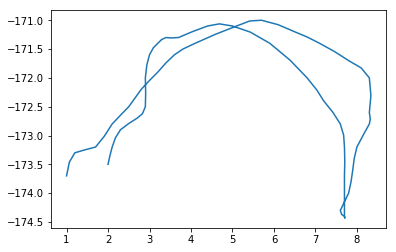

In [9]:
plt.plot(lat2, lon2)
plt.show()